### Explore the cryptocurrency course over history and see if meanigful predictions ca be made.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('myteststyle.mplstyle')

dataf = 'Bitcoin/Data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

timestamp2datetime = lambda T: datetime.utcfromtimestamp(T)
datetime2timestamp = lambda T: T.timestamp()

df = pd.read_csv(dataf, nrows=int(1e8)).dropna()
df.loc[:, 'Datetime'] = df.Timestamp.map(timestamp2datetime)
df.rename(columns={'Weighted_Price':'WPrice'}, inplace=True)
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),WPrice,Datetime
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31 07:52:00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31 15:50:00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31 16:59:00
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31 17:00:00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01 04:16:00


### First just plot the rate:

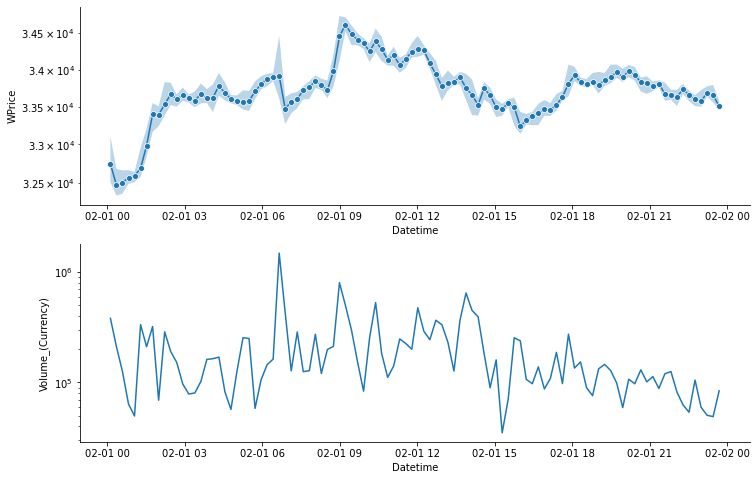

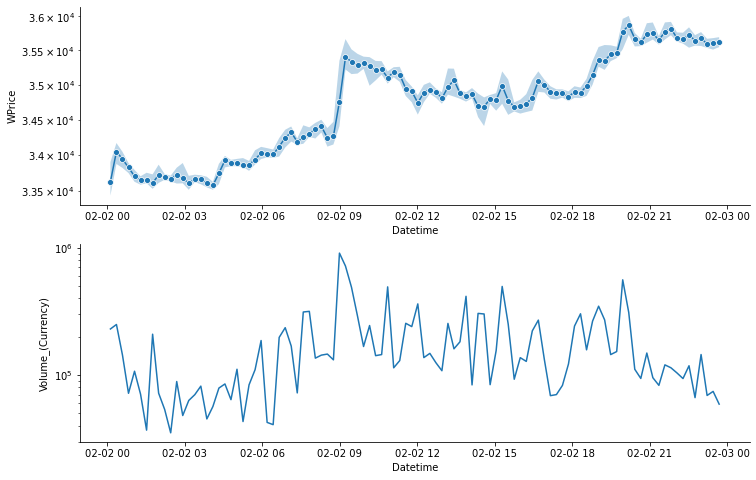

In [204]:
import seaborn as sns

def mask_df_on_date(df, window, end, datetime_col='Datetime'):
    """
    Mask the rate_df so that value between (end - window) and end are returned:
    """
    
        
    get_mask = lambda datetime_col: (end - window <= df.loc[:, datetime_col]) & (df.loc[:, datetime_col] < end)
    
    if isinstance(datetime_col, list):
        masks = []
        for col in datetime_col:
            masks.append(get_mask(col))
        mask = np.array(masks).T.any(axis=1)
    else:
        mask = get_mask(datetime_col)
    return df[mask]
    
def plot_rate(start_date, end_date, nwindow=100, preds_df=None):
    
    figs = plt.rcParams['figure.figsize'].copy()
    figs[1] *= 2
    _, (ax1, ax2) = plt.subplots(2, figsize=figs)

    
    mask = (df['Datetime'] > start_date) & (df['Datetime'] < end_date)
    
    nwindow = min(max(1,mask.sum()//100), nwindow)
    
    roller = df.loc[mask].rolling(nwindow)
    rolled = roller.mean() 
    rolled.loc[:, 'High'] = roller.max().loc[:, 'High']
    rolled.loc[:, 'Low'] = roller.min().loc[:, 'Low']
    rolled = rolled.iloc[nwindow-1::nwindow]
    rolled.loc[:, 'Datetime'] = rolled.Timestamp.map(timestamp2datetime)

    for ax, ylab, m in zip((ax1, ax2), ('WPrice', 'Volume_(Currency)'), ('o', '')):
        sns.lineplot(data=rolled, x='Datetime', y=ylab, ax=ax, marker=m)
        ax.semilogy()

    ax1.fill_between(rolled.Datetime, y1=rolled.Low, y2=rolled.High, alpha=.3)
    
    if preds_df is not None:
        preds_df = mask_df_on_date(preds_df, end_date - start_date, end_date, 
                                   datetime_col = ['pred_at_time', 'pred_for_time'])
        
        for idx in preds_df.index:
            X = [preds_df.loc[idx, 'pred_at_time'], preds_df.loc[idx, 'pred_for_time']]
            Y = [preds_df.loc[idx, 'rate_at_pred'], preds_df.loc[idx, 'rate_pred']]
            ax1.plot(X,Y, '-+', color='black')
        
    plt.show()
    

dt = timedelta(days=1)
start_date = datetime(2021, 2, 1)

for _ in range(2):
    end_date = start_date + dt
    plot_rate(start_date, end_date)
    start_date += dt
    


In [162]:
def make_rate_features(T, rate_df):
    """
    Generate features based on past rate at given moment in time.
    
    Attr:
        T : either POSIX time or datime.
        rate_df : Dataframe with rates given w.r.t. time.
    Return:
        features_dict : dictionary of feature value - {'feature_name':value,...}
        avg_price : within a time window used --> this is used to normalize the training data.
    """
    
    window = timedelta(days=1)
    
    if isinstance(T, (int, float)):
        datenow = timestamp2datetime(T)
    elif isinstance(T, datetime):
        datenow = T
    elif isinstance(T, np.datetime64):
        datenow = pd.Timestamp(T)
    else:
        raise ValueError(T)
    
    
    
        
    
    features_d = {}
    
    nhours = 8
    datetimecol='Datetime'
    rate_past = mask_df_on_date(rate_df, timedelta(hours=nhours), datenow, datetimecol)
    
    if len(rate_past)==0:
        avg_price=1
        cur_price=0
    else:
        avg_price = rate_past.WPrice.mean()
        cur_price = rate_past.WPrice.iloc[-1]
        
        
    
    nantozero = lambda val: 0 if np.isnan(val) else val
    
    for h in range(nhours-1):
        hour_price = mask_df_on_date(rate_past, 
                                     timedelta(hours=1), 
                                     datenow-timedelta(hours=h), 
                                     datetimecol).WPrice.mean()
        features_d[f'normed_prev_hour_price_(now-{h}h)'] = nantozero(hour_price/avg_price)
    
    nminutes = 20
    for minute in range(nminutes):
        minute_price = mask_df_on_date(rate_past, 
                                       timedelta(minutes=1), 
                                       datenow-timedelta(minutes=minute), 
                                       datetimecol).WPrice.mean()
        features_d[f'normed_prev_minute_price_(now-{minute}m)'] = nantozero(minute_price/avg_price)
    
    
    return features_d, cur_price
    
    


In [159]:
tfuture = timedelta(hours=1)


get_times = lambda datetimes, tfuture: datetimes - tfuture



### Make the train test split:

In [160]:
split_date = datetime(2021, 1, 1)
rate_test = df.loc[df.Datetime > split_date]
rate_train = df.loc[df.Datetime <= split_date]


Then lets generate the training data:

In [ ]:
import sys

train_size = 10000
test_size = 100
train_sample = rate_train.sample(train_size).sort_values('Timestamp') 


def make_X_y(df, tfuture, size=100):
    rate_col = f'rate_+{tfuture}'

    predict_index = df.sample(size).index
    
    predict_for_times = df.loc[predict_index].Datetime
    predict_at_times = get_times(predict_for_times, tfuture)
    

    feats, _ = make_rate_features(predict_at_times.iloc[0], df)
    nfeats = len(feats)

    X = pd.DataFrame(index=predict_at_times, 
                     data=np.zeros((size, nfeats)), 
                     columns=list(feats.keys()))
    y = pd.DataFrame(index=predict_index, 
                     columns=['rate_prop', 'rate_at_pred', 'rate_true', 'pred_for_time', 'pred_at_time'], 
                     dtype=float)
    i = 0
    for idx, predict_at_time, predict_for_time in zip(predict_index, 
                                                      predict_at_times, 
                                                      predict_for_times):
        
        if i%(size//100) == 0:
            f = datetime.now().strftime('%H:%M:%S') + ' => {:.02f}'.format(i/size)
            sys.stdout.write("\r" + str(f))
            sys.stdout.flush()
            
            
        rate = df.loc[idx, 'WPrice']
        feats, cur_rate = make_rate_features(predict_at_time, df)
        X.loc[predict_at_time, :] = feats
        y.loc[idx, 'rate_prop'] = rate/cur_rate
        y.loc[idx, 'rate_at_pred'] = cur_rate
        y.loc[idx, 'rate_true'] = rate
        y.loc[idx, 'pred_at_time'] = predict_at_time
        y.loc[idx, 'pred_for_time'] = predict_for_time
        i+=1
    
    return X, y.reindex().loc[:, 'rate_prop'], y

X_train, y_train, y_train_full = make_X_y(rate_train, tfuture, size=train_size)
X_test, y_test, y_test_full = make_X_y(rate_test, tfuture, size=test_size)

13:07:52 => 0.36

### Then do the ML...

In [206]:
from sklearn.tree import DecisionTreeRegressor


tree = DecisionTreeRegressor().fit(X_train, y_train)

preds = tree.predict(X_test)
preds

array([0.99983354, 1.01176771, 1.00073154, 0.99837348, 1.00762929,
       1.0042642 , 1.00021061, 1.00855049, 0.97913032, 0.99983354])

In [209]:
def make_preds_df(y_test_full, preds):
    preds_df = y_test_full.copy() 
    preds_df.loc[:, 'rate_prop_pred'] = pred
    preds_df.loc[:, 'rate_pred'] = preds_df.loc[:, 'rate_prop_pred']*preds_df.loc[:, 'rate_at_pred']
    
    return preds_df

preds_df = make_preds_df(y_test_full, preds)

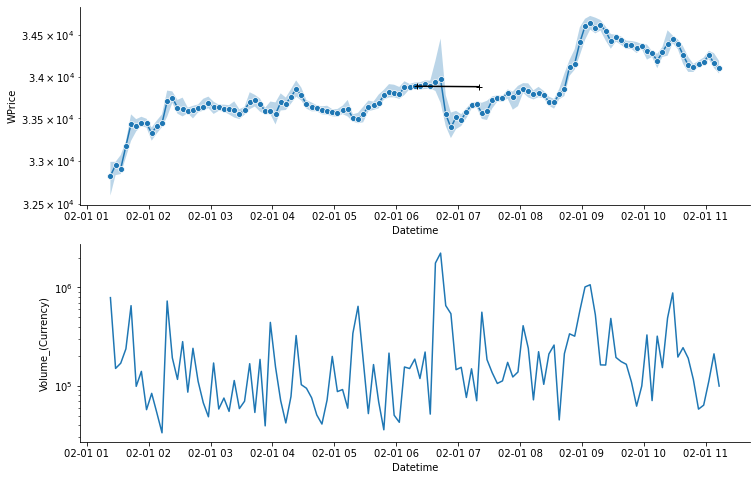

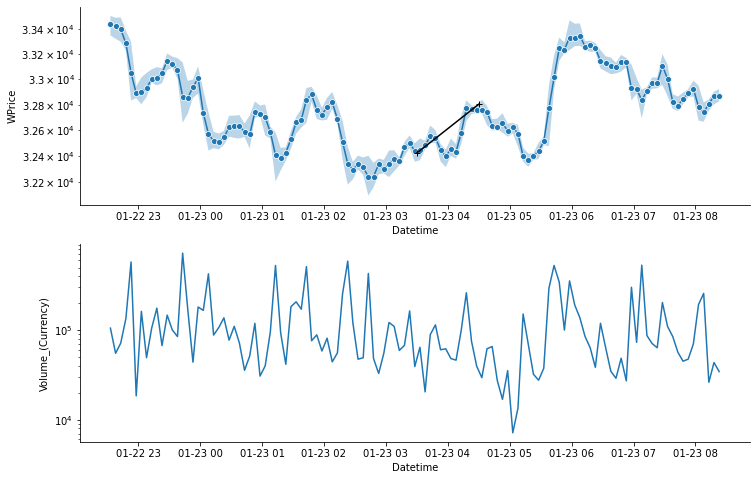

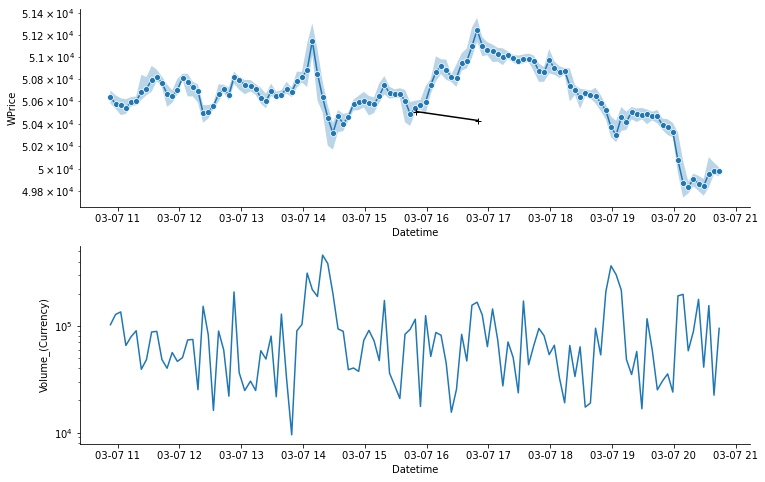

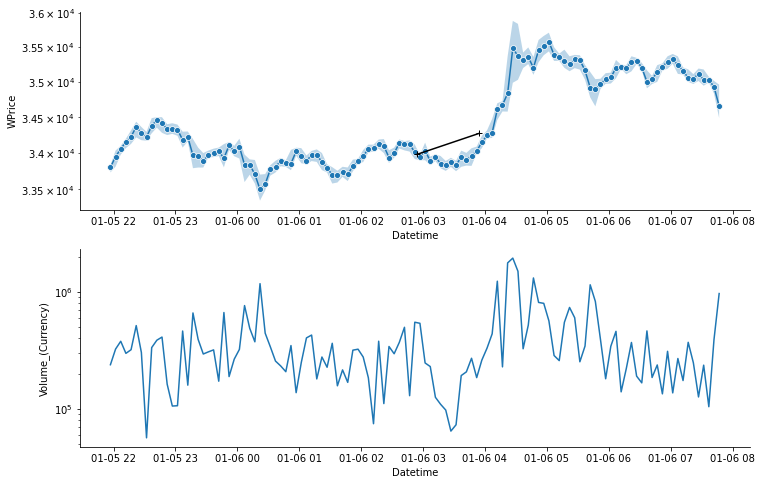

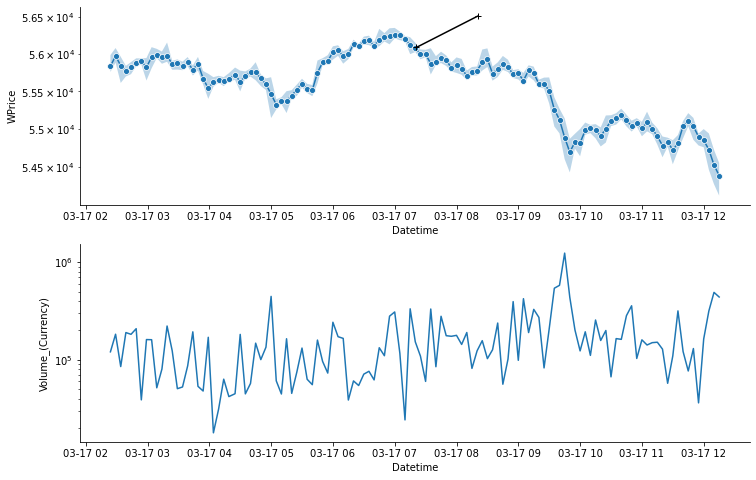

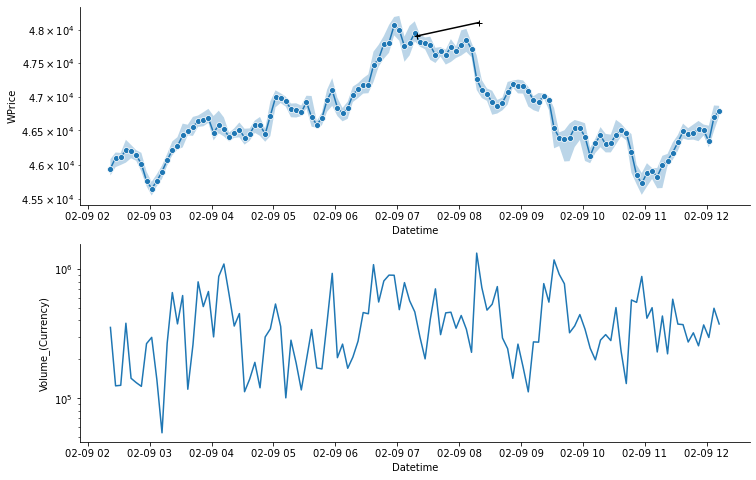

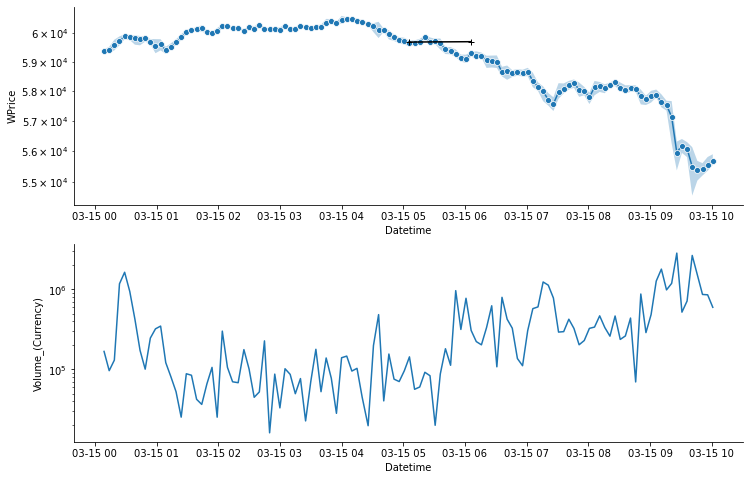

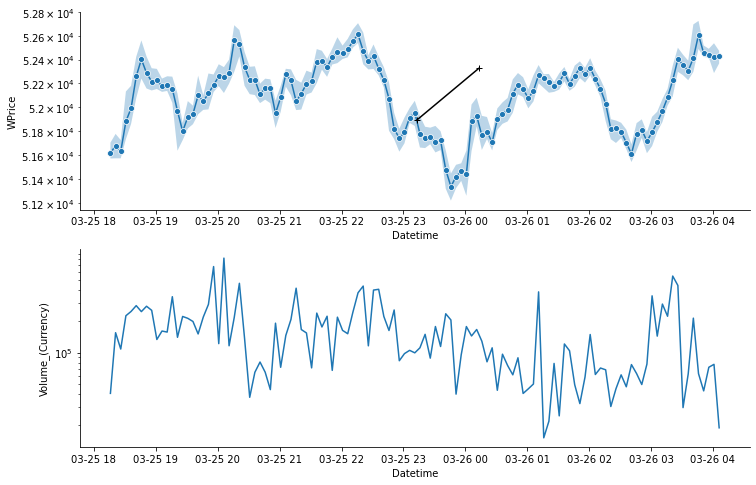

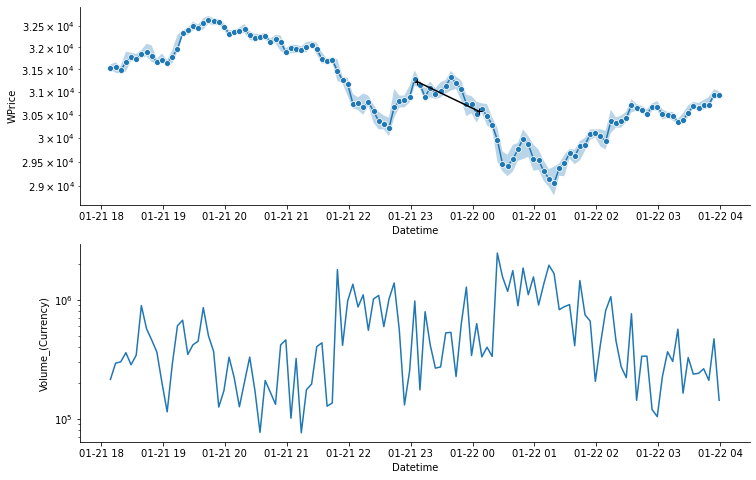

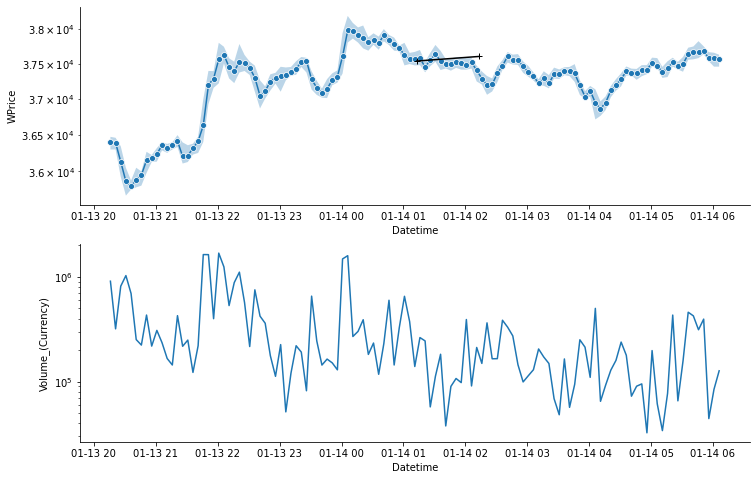

In [212]:
DT = timedelta(hours=5)
for i in range(len(preds_df)):
    
    pred_at = preds_df.iloc[i].pred_at_time
    start_date = pred_at - DT #timedelta(days=1)
    end_date = pred_at + DT #pred_df.pred_for_time.max() #
    plot_rate(start_date, end_date, preds_df=preds_df)